In [12]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
%matplotlib inline

In [5]:
df=pd.read_csv('../datasets/defaultcc.csv', header=1)

In [7]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [8]:
df.columns

Index([u'ID', u'LIMIT_BAL', u'SEX', u'EDUCATION', u'MARRIAGE', u'AGE',
       u'PAY_0', u'PAY_2', u'PAY_3', u'PAY_4', u'PAY_5', u'PAY_6',
       u'BILL_AMT1', u'BILL_AMT2', u'BILL_AMT3', u'BILL_AMT4', u'BILL_AMT5',
       u'BILL_AMT6', u'PAY_AMT1', u'PAY_AMT2', u'PAY_AMT3', u'PAY_AMT4',
       u'PAY_AMT5', u'PAY_AMT6', u'default payment next month'],
      dtype='object')

In [9]:
df.shape

(30000, 25)

In [10]:
df['default'] = df['default payment next month']

In [14]:
data = df[['default', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']]
data.head()

,default,SEX,EDUCATION,MARRIAGE,AGE
0,1,2,2,1,24
1,1,2,2,2,26
2,0,2,2,2,34
3,0,2,2,1,37
4,0,1,2,1,57


In [15]:
with pm.Model() as model:
    pm.glm.glm('default ~ SEX + EDUCATION + MARRIAGE + AGE', data, family=pm.glm.families.Binomial())
    trace_logistic_model = pm.sample(2000, pm.NUTS(), progressbar=True)

Applied logodds-transform to p and added transformed p_logodds_ to model.
100%|██████████| 2000/2000 [06:26<00:00,  4.24it/s]


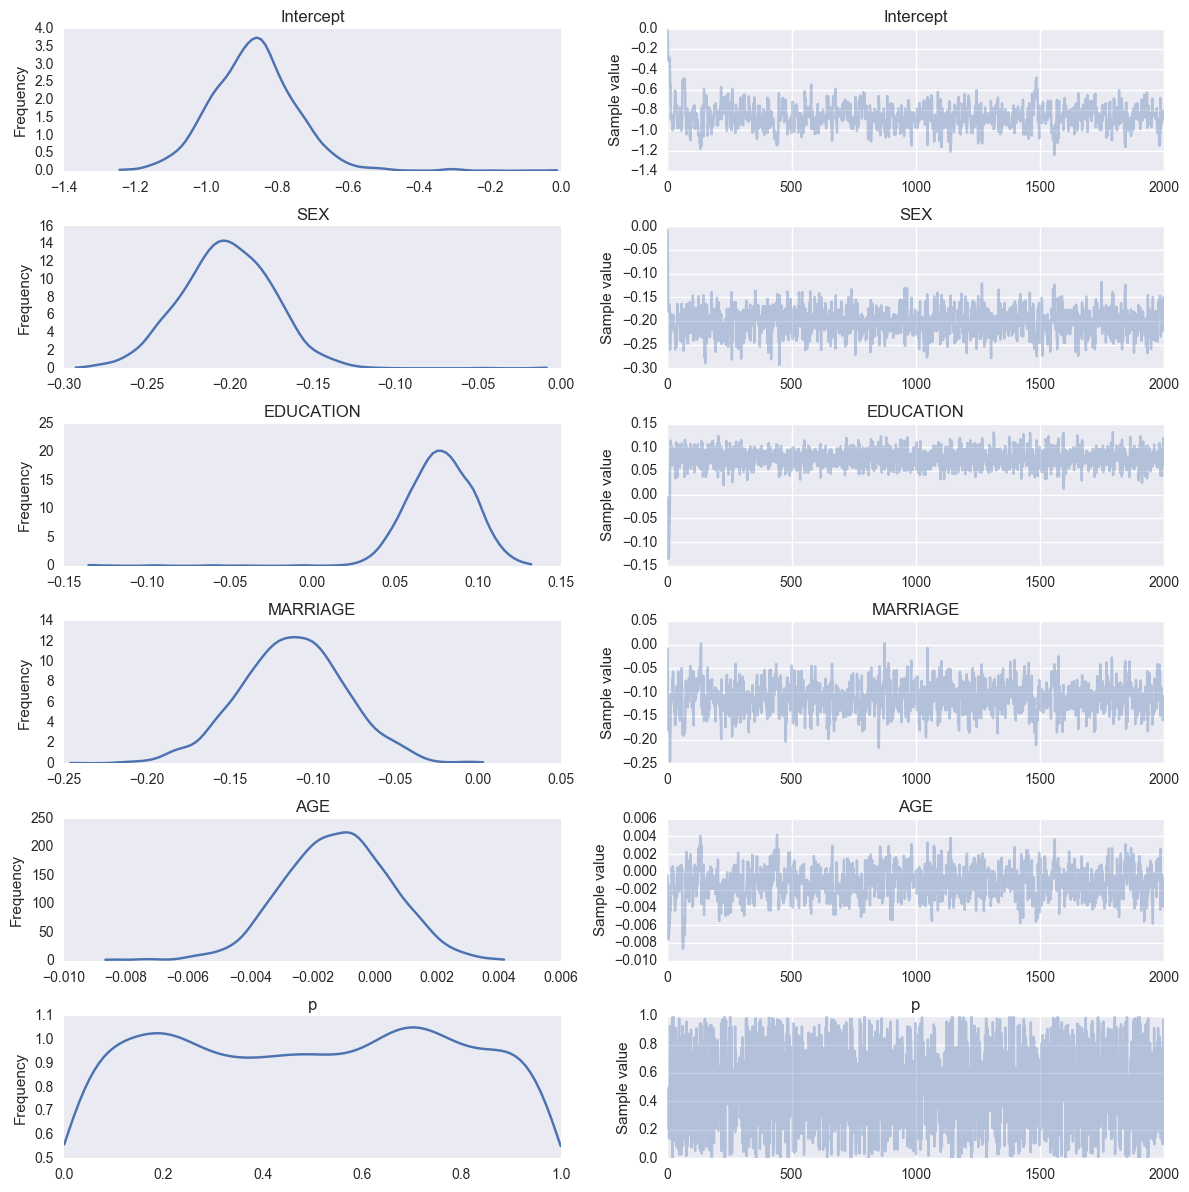

In [16]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace_logistic_model)
plt.tight_layout()

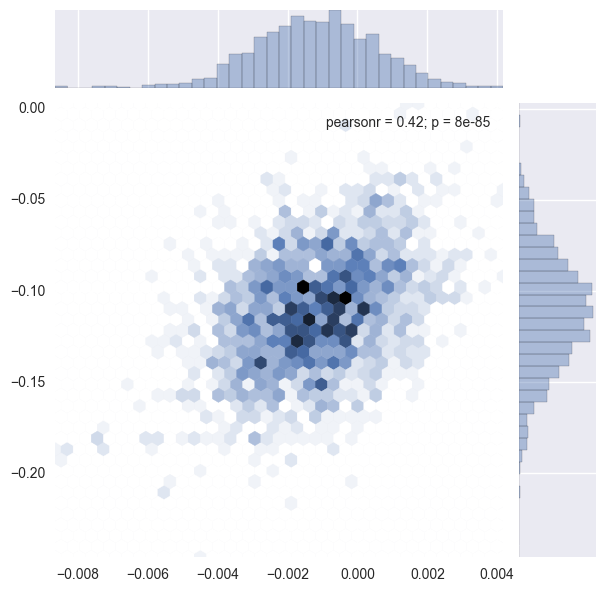

In [17]:
sns.jointplot(trace_logistic_model['AGE'], trace_logistic_model['MARRIAGE'], kind='hex')

In [18]:
pm.summary(trace_logistic_model)


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.864           0.122            0.007            [-1.089, -0.638]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.088         -0.943         -0.864         -0.794         -0.634


SEX:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.202           0.028            0.001            [-0.255, -0.147]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.256         -0.219         -0.201         -0.183         -0.148


EDUCATION:

  Mean             SD               MC Error         95% HPD interval
  -------------

In [19]:
for coef in ['Intercept', 'SEX', 'AGE', 'MARRIAGE', 'EDUCATION']:
    print coef, ': ', np.mean(trace_logistic_model[coef])

Intercept :  -0.864074901498
SEX :  -0.201643857134
AGE :  -0.00121290401079
MARRIAGE :  -0.11180389595
EDUCATION :  0.0767106862145


In [20]:
import theano.tensor as T

In [24]:
data['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [57]:
def logistic(l):
    return 1 / (1 + T.exp(-l))

with pm.Model() as test_model:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=2, sd=10)
#     sex_coef=pm.Categorical('sex', )
#     sex_coef = pm.Bernoulli('sex', p=0.5)
    sex_coef = pm.Normal('sex', mu=0, sd=10)
    marriage_coef = pm.Normal('marriage', mu=2, sd=10)
#     marriage_coef = pm.Categorical('marriage', p=np.array([0.53, 0.45, 0.01, 0.01]))
    
    y_hat = alpha + sex_coef * data['SEX'] + marriage_coef * data['MARRIAGE']

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=logistic(y_hat), observed=data['default'])
    
    start_MAP = pm.find_MAP()
    traces_new_logistic = pm.sample(2000, start=start_MAP, step=pm.NUTS(), njobs=-1, progressbar=True)

100%|██████████| 2000/2000 [06:54<00:00,  5.33it/s]


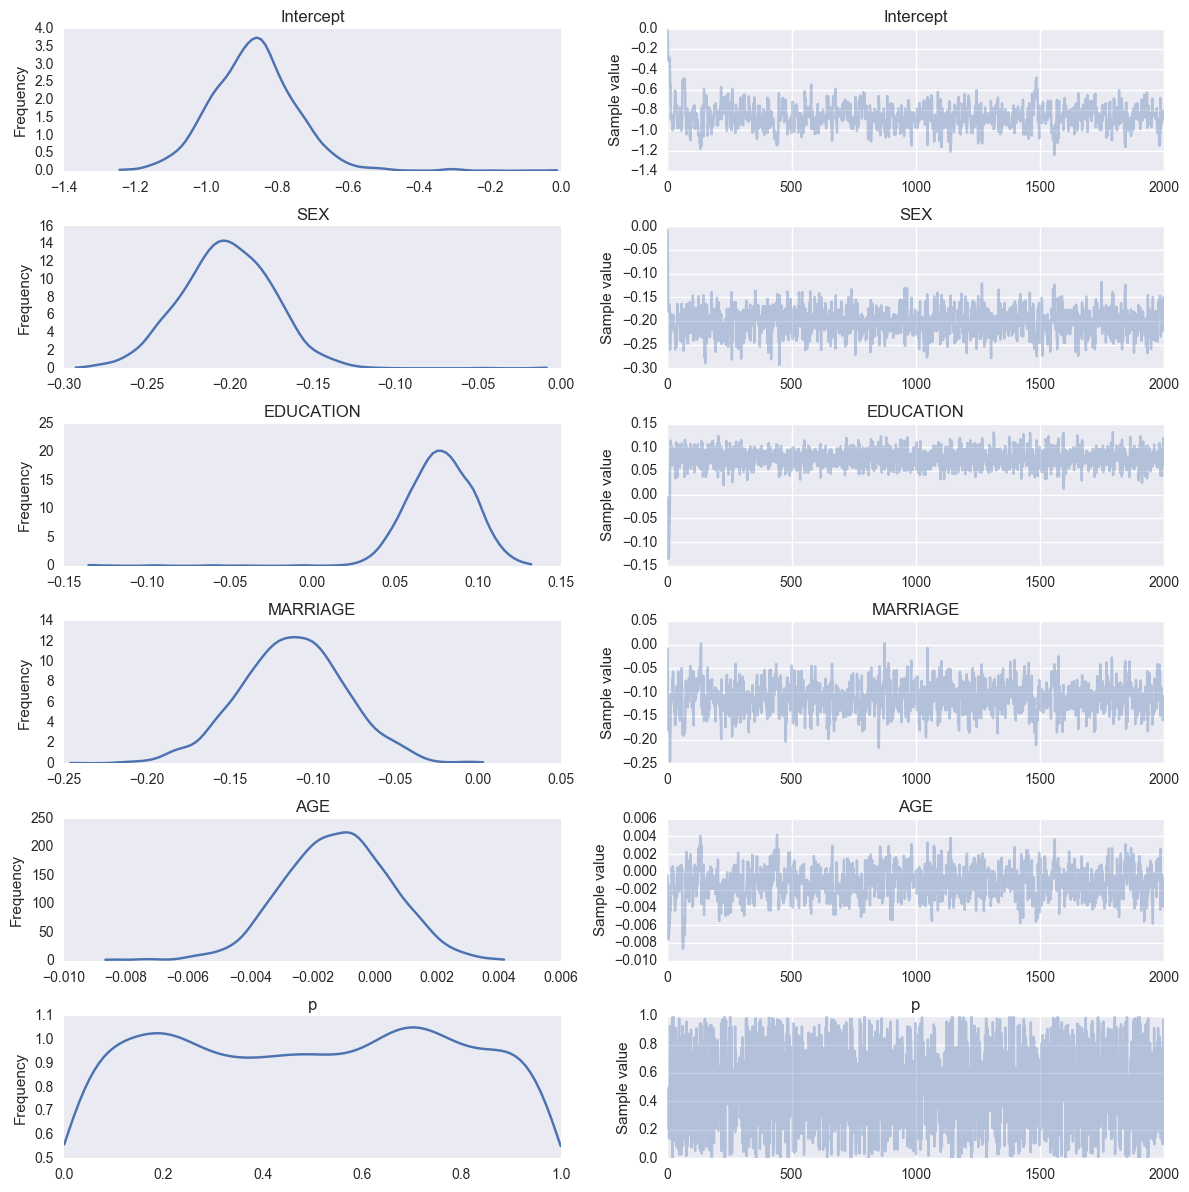

In [51]:
pm.traceplot(trace_logistic_model)
plt.tight_layout()

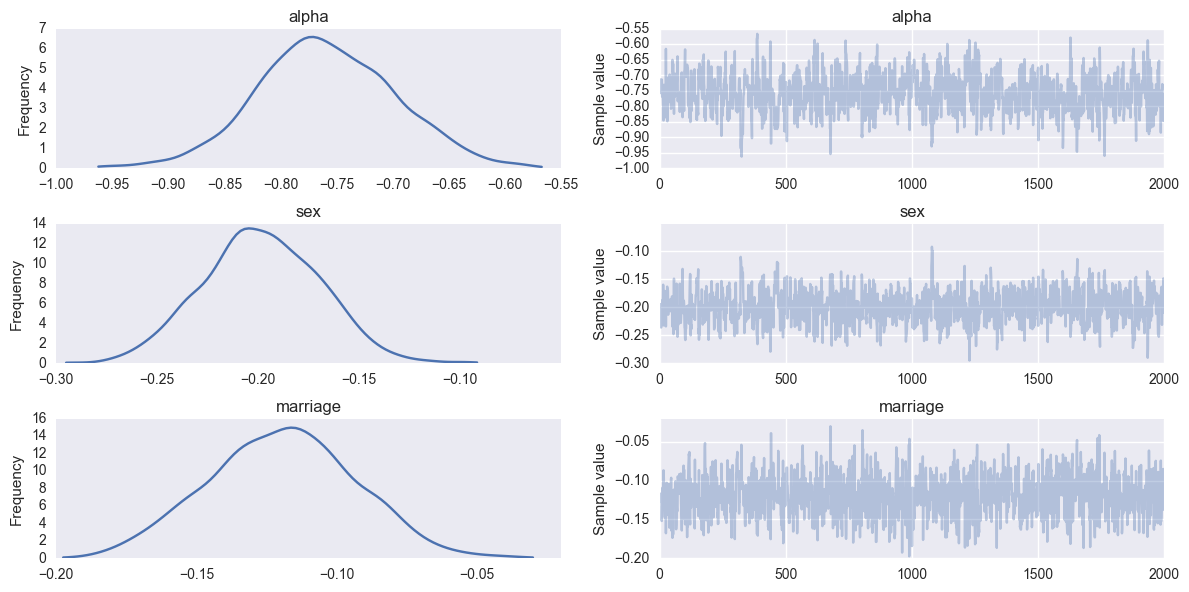

In [58]:
pm.traceplot(traces_new_logistic)
plt.tight_layout()

In [31]:
pm.summary(traces_new_logistic)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -3.506           1.244            0.048            [-6.637, -2.461]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -7.277         -3.796         -2.918         -2.884         -2.633


sex:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.461            0.498            0.014            [0.000, 1.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          0.000          0.000          1.000          1.000


marriage:

  Mean             SD               MC Error         95% HPD interval
  ---------------------

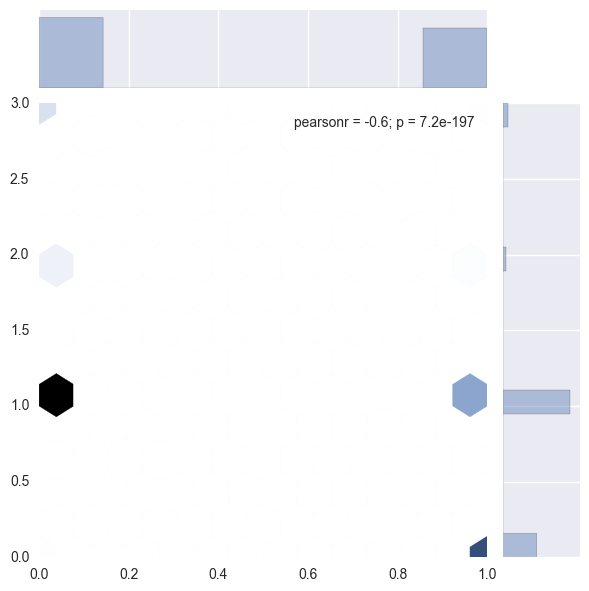

In [33]:
sns.jointplot(traces_new_logistic['sex'], traces_new_logistic['marriage'], kind='hex')

In [41]:
def predict(dictionary, model):
    coefs=sum([(model[key]*value) for key, value in dictionary.items()])
    coefs+=model['alpha']
    return 1/(1+np.exp(-coefs))

In [42]:
def plotting_function(y_series):
    plt.scatter(np.linspace(0, len(y_series), len(y_series)), 
               y_series)
    plt.hlines(y_series.mean(), 0, len(y_series))
    plt.xlabel('Model iteration')
    plt.ylabel('P(Y = 1)')
    plt.show()

In [43]:
plotting_function(predict({'sex':2, 'marriage':2}, traces_new_logistic))

TypeError: Cannot cast ufunc add output from dtype('float64') to dtype('int64') with casting rule 'same_kind'